# Secure Data Disclosure: Client side

This notebook showcases how researcher could use the Secure Data Disclosure system. It explains the different functionnalities provided by the `lomas-client` client library to interact with the secure server.

The secure data are never visible by researchers. They can only access to differentially private responses via queries to the server.

Each user has access to one or multiple projects and for each dataset has a limited budget with $\epsilon$ and $\delta$ values.

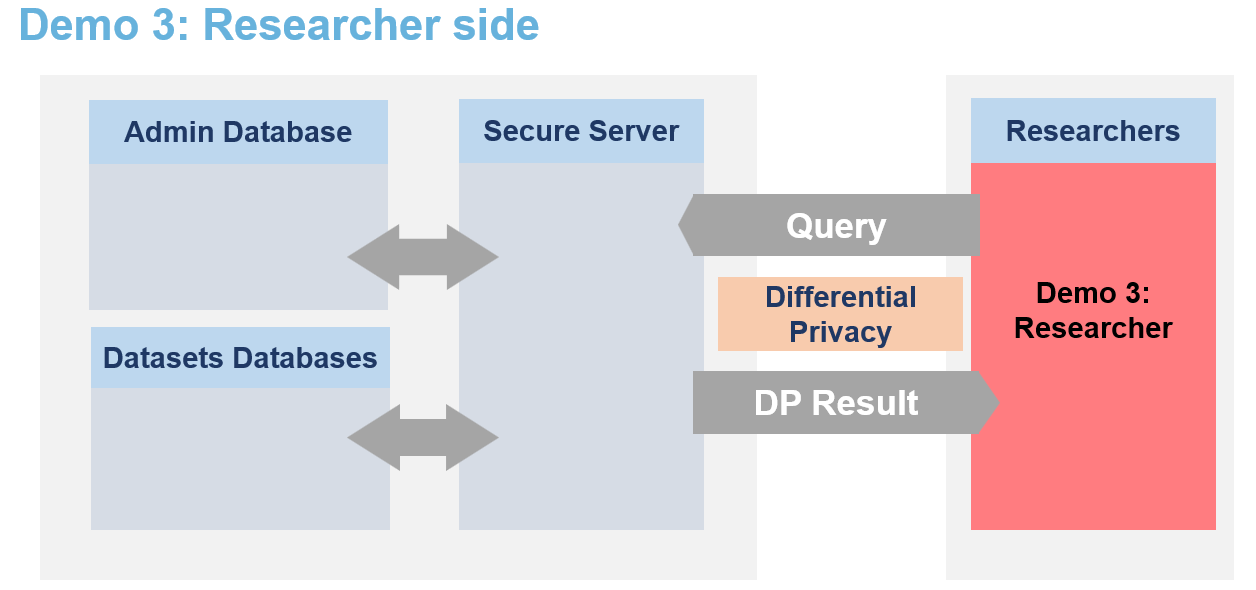

In [1]:
from IPython.display import Image
Image(filename="images/image_demo_client.png", width=800)

🐧🐧🐧
In this notebook the researcher is a penguin researcher named Dr. Antarctica. She aims to do a grounbdbreaking research on various penguins dimensions.

Therefore, the powerful queen Icerbegina 👑 had the data collected. But in order to get the penguins to agree to participate she promised them that no one would be able to look at the data and that no one would be able to guess the bill width of any specific penguin (which is very sensitive information) from the data. Nobody! Not even the researchers. The queen hence stored the data on the Secure Data Disclosure Server and only gave a small budget to Dr. Antarctica.

This is not a problem for Dr. Antarctica as she does not need to see the data to make statistics thanks to the Secure Data Disclosure Client library `lomas-client`. 
🐧🐧🐧

## Step 1: Install the library
To interact with the secure server on which the data is stored, Dr.Antartica first needs to install the library `lomas-client` on her local developping environment. 

It can be installed via the pip command:

In [2]:
#!pip install lomas-client

In [3]:
from lomas_client import Client
import numpy as np

## Step 2: Initialise the client

Once the library is installed, a Client object must be created. It is responsible for sending sending requests to the server and processing responses in the local environment. It enables a seamless interaction with the server. 

To create the client, Dr. Antartica needs to give it a few parameters:
- a url: the root application endpoint to the remote secure server.
- user_name: her name as registered in the database (Dr. Alice Antartica)
- dataset_name: the name of the dataset that she wants to query (PENGUIN)

She will only be able to query on the real dataset if the queen Icergina has previously made her an account in the database, given her access to the PENGUIN dataset and has given her some epsilon and delta credit (as is done in the Admin Notebook for Users and Datasets management).

In [4]:
APP_URL = "http://lomas_server_dev:80"
# APP_URL = "https://lomas-server.lab.sspcloud.fr"
USER_NAME = "Dr. Antartica"
DATASET_NAME = "PENGUIN"
client = Client(url=APP_URL, user_name = USER_NAME, dataset_name = DATASET_NAME)

And that's it for the preparation. She is now ready to use the various functionnalities offered by `lomas_client`.

## Step 3: Understand the functionnalities of the library

### Getting dataset metadata

Dr. Antartica has never seen the data and as a first step to understand what is available to her, she would like to check the metadata of the dataset. Therefore, she just needs to call the `get_dataset_metadata()` function of the client. As this is public information, this does not cost any budget.

This function returns metadata information in a format based on [SmartnoiseSQL dictionary format](https://docs.smartnoise.org/sql/metadata.html#dictionary-format), where among other, there is information about all the available columns, their type, bound values (see Smartnoise page for more details). Any metadata is required for Smartnoise-SQL is also required here and additional information such that the different categories in a string type column column can be added.

In [5]:
penguin_metadata = client.get_dataset_metadata()
penguin_metadata

{'max_ids': 1,
 'row_privacy': True,
 'censor_dims': False,
 'columns': {'species': {'type': 'string',
   'cardinality': 3,
   'categories': ['Adelie', 'Chinstrap', 'Gentoo']},
  'island': {'type': 'string',
   'cardinality': 3,
   'categories': ['Torgersen', 'Biscoe', 'Dream']},
  'bill_length_mm': {'type': 'float', 'lower': 30.0, 'upper': 65.0},
  'bill_depth_mm': {'type': 'float', 'lower': 13.0, 'upper': 23.0},
  'flipper_length_mm': {'type': 'float', 'lower': 150.0, 'upper': 250.0},
  'body_mass_g': {'type': 'float', 'lower': 2000.0, 'upper': 7000.0},
  'sex': {'type': 'string',
   'cardinality': 2,
   'categories': ['MALE', 'FEMALE']}}}

Based on this Dr. Antartica knows that there are 7 columns, 3 of string type (species, island, sex) with their associated categories (i.e. the species column has 3 possibilities: 'Adelie', 'Chinstrap', 'Gentoo') and 4 of float type (bill length, bill depth, flipper length and body mass) with their associated bounds (i.e. the body mass of penguin ranges from 2000 to 7000 gramms). She also knows based on the field `max_ids: 1` that each penguin can only be once in the dataset and on the field `row_privacy: True` that each row represents a single penguin. 

### Get a dummy dataset

Now, that she has seen and understood the metadata, she wants to get an even better understanding of the dataset (but is still not able to see it). A solution to have an idea of what the dataset looks like it to create a dummy dataset. 

Based on the public metadata of the dataset, a random dataframe can be created created. By default, there will be 100 rows and the seed is set to 42 to ensure reproducibility, but these 2 variables can be changed to obtain different dummy datasets.
Getting a dummy dataset does not affect the budget as there is no differential privacy here. It is not a synthetic dataset and all that could be learn here is already present in the public metadata (it is created randomly on the fly based on the metadata).

Dr. Antartica first create a dummy dataset with 200 rows and chooses a seed of 0.

In [6]:
NB_ROWS = 200
SEED = 0

In [7]:
df_dummy = client.get_dummy_dataset(
    nb_rows = NB_ROWS, 
    seed = SEED
)

print(df_dummy.shape)
df_dummy.head()

(200, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Gentoo,Biscoe,49.208473,16.117959,190.125950,2873.291927,FEMALE
1,Gentoo,Torgersen,55.031628,19.963435,242.929142,3639.940005,FEMALE
2,Chinstrap,Torgersen,51.096718,16.777518,159.961493,5401.743330,MALE
3,Adelie,Biscoe,49.070911,14.796037,244.530153,2316.038092,MALE
4,Chinstrap,Biscoe,44.827918,13.246787,236.948853,5036.246870,FEMALE


### Query on dummy dataset
Now that she has an idea of what the data looks like, she wants to start querying the real dataset for her research. 

However, her budget is limited and it would be a waste to spend it by mistake on a coding error. Therefore the client/server pipeline has functionnal testing capabilities for the users. It is possible to test a query on a `dummy` dataset to ensure that everything is working properly. Dr. Antartica will not be able to use the results of a dummy query for her analysis (as the data is random) but if the query on the dummy dataset works, she can be confident that her query will also work on the real dataset.
This functionnal testing on the dummy does not have any impact on the budget as it is on random data only.

To test on the dummy data instead of the real data, the function call is exactly the same with the only exception of the flag `dummy=True`. In the following cell, she will test with `smartnoise_query` but it is the same flag for `opendp_query`. She can optionnaly give two additional parameters to set the seed and the number of rows of the dummy dataset.

Another more advanced possibility for functionnal tests with the dummy is to compare results of queries on a local dummy and the remote dummy with a very high budget: 
- create a local dummy on the notebook with a specific seed and number of rows
- compute locally the wanted query on this local dummy with python functions like numpy
- query the server on the same remote dummy with (`dummy=True`, same seed and same number of row) and a very big buget to limit noise as much as possible (don't worry this won't cost any real budget)
- compare and verify that the local and remote dummy have similar results.

#### Average and number of rows with smartnoise-sql library on remote dummy

Dr. Antartica will now try a query to get the number of penguin and their average bill length (in mm) on the dummy dataset. She does not forget to 
- set the `dummy` flag to True
- set very high budget values to be able to compare results with a similar local dummy (with the same seed and number of rows) if she wants to verify that the function do what is expected. Here she will just check that the number of rows is close to what she sets as parameter.

In [8]:
# Number of penguin and average bill length in mm
QUERY = "SELECT COUNT(*) AS nb_penguins, \
        AVG(bill_length_mm) AS avg_bill_length_mm \
        FROM df"

In [9]:
# On the remote server dummy dataframe
dummy_res = client.smartnoise_query(
    query = QUERY,  
    epsilon = 100.0,
    delta = 0.99,
    dummy = True, 
    nb_rows = NB_ROWS,
    seed = SEED
)

In [10]:
print(f"Average bill length in remote dummy: {np.round(dummy_res['query_response']['avg_bill_length_mm'][0], 2)}mm.")
print(f"Number of rows in remote dummy: {np.round(dummy_res['query_response']['nb_penguins'][0], 2)}.")

Average bill length in remote dummy: 47.52mm.
Number of rows in remote dummy: 199.


No functionnal errors happened and the estimated number of rows is very close (if not equal) to the number of rows that she set for the dummy dataframe. She is now even more confident in using her query on the server.

### Get current budget

It is the first time that Dr. Antartica connects to the server and she wants to know how much buget the queen assigned her.
Therefore, she calls the fonction `get_initial_budget`.

In [11]:
client.get_initial_budget()

{'initial_epsilon': 10.0, 'initial_delta': 0.005}

She sees that she has 10.0 epsilon and 0.005 epsilon at her disposal.

Then she checks her total spent budget `get_total_spent_budget`. As she only did queries on metadata on dummy dataframes, this should still be 0.

In [12]:
client.get_total_spent_budget()

{'total_spent_epsilon': 0.0, 'total_spent_delta': 0.0}

It will also be useful to know what the remaining budget is. Therefore, she calls the function `get_remaining_budget`. It just substarcts the total spent budget from the initial budget.

In [13]:
client.get_remaining_budget()

{'remaining_epsilon': 10.0, 'remaining_delta': 0.005}

As expected, for now the remaining budget is equal to the inital budget.

### Estimate cost of a query
Another safeguard is the functionnality to estimate the cost of a query. As in OpenDP and SmartnoiseSQL, the budget that will by used by a query might be slightly different than what is asked by the user. The `estimate cost` function returns the estimated real cost of any query.

Again, of course, this will not impact the user's budget.

Dr. Antartica checks the budget that computing the average bill length will really cost her if she asks the query with an `epsilon` and a `delta`.

In [14]:
EPSILON = 0.5
DELTA = 1e-4

In [15]:
client.estimate_smartnoise_cost(
    query = QUERY, 
    epsilon = EPSILON, 
    delta = DELTA
)

{'epsilon_cost': 1.5, 'delta_cost': 0.00014999500000001387}

This query would actually cost her 1.5 epsilon and delta 1.4999e-4. She decides that it is good enough.

### Query on real private dataset with smartnoise-sql
Now that all the safeguard functions were tested, Dr. Antartica is ready to query on the real dataset and get a differentially private response of the number of penguins and average bill length. By default, the flag `dummy` is False so setting it is optional. She uses the values of `epsilon` and `delta` that she selected just before.

Careful: This command DOES spend the budget of the user and the remaining budget is updated for every query.

In [16]:
client.get_remaining_budget()

{'remaining_epsilon': 10.0, 'remaining_delta': 0.005}

In [17]:
response = client.smartnoise_query(
    query = QUERY,  
    epsilon = EPSILON, 
    delta = DELTA,
    dummy = False # Optionnal
)

In [18]:
nb_penguins = response['query_response']['nb_penguins'].iloc[0]
print(f"Number of penguins in real data: {nb_penguins}.")

avg_bill_length = np.round(response['query_response']['avg_bill_length_mm'].iloc[0], 2)
print(f"Average bill length of penguins in real data: {avg_bill_length}mm.")

Number of penguins in real data: 343.
Average bill length of penguins in real data: 44.12mm.


After each query on the real dataset, the budget informations are also returned to the researcher. It is possible possible to check the remaining budget again afterwards:

In [19]:
response

{'requested_by': 'Dr. Antartica',
 'query_response':    nb_penguins  avg_bill_length_mm
 0          342           43.131892,
 'spent_epsilon': 1.5,
 'spent_delta': 0.00014999500000001387}

In [20]:
client.get_remaining_budget()

{'remaining_epsilon': 8.5, 'remaining_delta': 0.004850004999999986}

As can be seen in `get_total_spent_budget()`, it is the budget estimated with `estimate_smartnoise_cost()` that was spent.

In [21]:
client.get_total_spent_budget()

{'total_spent_epsilon': 1.5, 'total_spent_delta': 0.00014999500000001387}

Dr. Antartica has now a differentially private estimation of the number of penguins in the dataset and is confident to use the library for the rest of her analyses.

## Step 4: Penguin statistics with opendp

In [22]:
import opendp as dp
import opendp.transformations as trans
import opendp.measurements as meas

### Confidence intervals for bill length over the whole population

She is first interested to have a better idea of the distribution of bill length of all species. She already has the count and average from the previous step, so she only needs the variance values.

She first checks the metadata again to use the relevant values in the pipeline.

In [23]:
penguin_metadata

{'max_ids': 1,
 'row_privacy': True,
 'censor_dims': False,
 'columns': {'species': {'type': 'string',
   'cardinality': 3,
   'categories': ['Adelie', 'Chinstrap', 'Gentoo']},
  'island': {'type': 'string',
   'cardinality': 3,
   'categories': ['Torgersen', 'Biscoe', 'Dream']},
  'bill_length_mm': {'type': 'float', 'lower': 30.0, 'upper': 65.0},
  'bill_depth_mm': {'type': 'float', 'lower': 13.0, 'upper': 23.0},
  'flipper_length_mm': {'type': 'float', 'lower': 150.0, 'upper': 250.0},
  'body_mass_g': {'type': 'float', 'lower': 2000.0, 'upper': 7000.0},
  'sex': {'type': 'string',
   'cardinality': 2,
   'categories': ['MALE', 'FEMALE']}}}

She can define the columns names and the bounds of the relevant column.

In [24]:
columns = ["species", "island", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g", "sex"]

In [27]:
bill_length_min = penguin_metadata['columns']['bill_length_mm']['lower']
bill_length_max = penguin_metadata['columns']['bill_length_mm']['upper']
bill_length_min, bill_length_max

(30.0, 65.0)

She can now define the pipeline of the transformation to have the variance that she wants on the data:

In [28]:
bill_length_transformation_pipeline = (
    trans.make_split_dataframe(separator=",", col_names=columns) >>
    trans.make_select_column(key="bill_length_mm", TOA=str) >>
    trans.then_cast_default(TOA=float) >>
    trans.then_clamp(bounds=(bill_length_min, bill_length_max)) >>
    trans.then_resize(size=nb_penguins.tolist(), constant=avg_bill_length) >>
    trans.then_variance()
)

However, when she tries to execute it on the server, she has an error (see below). 

In [29]:
# Expect to fail !!!
client.opendp_query(
    opendp_pipeline = bill_length_transformation_pipeline,
    dummy=True
)

Server error status 400: {"InvalidQueryException":"The pipeline provided is not a measurement. It cannot be processed in this server."}


This is because the server will only allow measurement pipeline with differentially private results. She adds Laplacian noise to the pipeline and should be able to instantiate the pipeline.

In [30]:
var_bill_length_measurement_pipeline = (
    bill_length_transformation_pipeline >>
    meas.then_laplace(scale=5.0)
)

Now that there is a measurement, she is able to apply the pipeline on the dummy dataset of the server.

In [31]:
dummy_var_res = client.opendp_query(
    opendp_pipeline = var_bill_length_measurement_pipeline, 
    dummy=True
)
print(f"Dummy result for variance: {np.round(dummy_var_res['query_response'], 2)}")

Dummy result for variance: 32.44


With opendp, the function `estimate_opendp_cost` is particularly useful to estimate the used `epsilon` and `delta` based on the `scale` value.

In [32]:
cost_res = client.estimate_opendp_cost(
    opendp_pipeline = var_bill_length_measurement_pipeline
)
cost_res

{'epsilon_cost': 0.7163742690067888, 'delta_cost': 0}

She can now execute the query on the real dataset.

In [33]:
var_res = client.opendp_query(
    opendp_pipeline = var_bill_length_measurement_pipeline, 
)

In [34]:
print(f"Number of penguins: {nb_penguins} (from previous smartnoise-sql query).")

print(f"Average bill length: {np.round(avg_bill_length, 2)} (from previous smartnoise-sql query).")

var_bill_length = var_res['query_response']
print(f"Variance of bill length: {np.round(var_bill_length, 3)} (from opendp query).")

Number of penguins: 342 (from previous smartnoise-sql query).
Average bill length: 43.13 (from previous smartnoise-sql query).
Variance of bill length: 10.184 (from opendp query).


She can now do all the postprocessing that she wants with the returned data without adding any privacy risk. 

In [35]:
# Get standard error
standard_error = np.sqrt(var_bill_length/nb_penguins)
print(f"Standard error of bill length: {np.round(standard_error, 2)}.")

Standard error of bill length: 0.17.


In [36]:
 # Compute the 95% confidence interval
ZSCORE = 1.96
lower_bound = np.round(avg_bill_length - ZSCORE*standard_error, 2)
upper_bound = np.round(avg_bill_length + ZSCORE*standard_error, 2)
print(f"The 95% confidence interval of the bill length of all penguins is [{lower_bound}, {upper_bound}].")

The 95% confidence interval of the bill length of all penguins is [42.79, 43.47].


### Count per species

She can also creates an histogram of the number of penguin per species.

She first extract the categories from the metadata:

In [38]:
categories = penguin_metadata['columns']['species']['categories']
categories

['Adelie', 'Chinstrap', 'Gentoo']

Then, writes the pipeline:

In [39]:
species_count_pipeline = (
    trans.make_split_dataframe(separator=",", col_names=columns) >>
    trans.make_select_column(key="species", TOA=str) >>
    trans.then_count_by_categories(categories=categories) >>
    meas.then_laplace(scale=0.5)
)

Verify it works on the dummy:

In [40]:
dummy_res = client.opendp_query(
    opendp_pipeline = species_count_pipeline, 
    dummy=True
)
print(f"Dummy result for histogram: {dummy_res['query_response']}")

Dummy result for histogram: [38, 33, 29, 0]


Checks the required cost:

In [41]:
cost_res = client.estimate_opendp_cost(
    opendp_pipeline = species_count_pipeline
)
cost_res

{'epsilon_cost': 2.0, 'delta_cost': 0}

And finally apply the pipeline on the real dataset:

In [42]:
species_counts_res = client.opendp_query(
    opendp_pipeline = species_count_pipeline, 
)

In [43]:
species_counts_res

{'requested_by': 'Dr. Antartica',
 'query_response': [152, 67, 123, 0],
 'spent_epsilon': 2.0,
 'spent_delta': 0}

In [44]:
for i, count in enumerate(species_counts_res['query_response']):
    if i == len(categories):
        print(f"Species Unknown has {count} penguins.")
    else:
        print(f"Species {categories[i]} has {count} penguins.")

Species Adelie has 152 penguins.
Species Chinstrap has 67 penguins.
Species Gentoo has 123 penguins.
Species Unknown has 0 penguins.


## Step 5: See archives of queries

She now wants to verify all the queries that she did on the real data. It is possible because an archive of all queries is kept in a secure database. With a function call she can see her queries, budget and associated responses.

In [45]:
previous_queries = client.get_previous_queries()
previous_queries

[{'user_name': 'Dr. Antartica',
  'dataset_name': 'PENGUIN',
  'client_input': {'query_str': 'SELECT COUNT(*) AS nb_penguins,         AVG(bill_length_mm) AS avg_bill_length_mm         FROM df',
   'dataset_name': 'PENGUIN',
   'epsilon': 0.5,
   'delta': 0.0001,
   'mechanisms': {},
   'postprocess': True},
  'response': {'requested_by': 'Dr. Antartica',
   'query_response': {'index': [0],
    'columns': ['nb_penguins', 'avg_bill_length_mm'],
    'data': [[342, 43.13189211774378]],
    'index_names': [None],
    'column_names': [None]},
   'spent_epsilon': 1.5,
   'spent_delta': 0.00014999500000001387},
  'timestamp': 1714988610.19844,
  'dp_librairy': 'smartnoise_sql'},
 {'user_name': 'Dr. Antartica',
  'dataset_name': 'PENGUIN',
  'client_input': {'dataset_name': 'PENGUIN',
   'opendp_json': <opendp.mod.Measurement at 0x7f3bac567b60>,
   'fixed_delta': None},
  'response': {'requested_by': 'Dr. Antartica',
   'query_response': 10.184409589415381,
   'spent_epsilon': 0.716374269006788